# General

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, lombscargle
import pandas as pd
from scipy.constants import c
import os
from scipy.fft import fft, ifft, fftfreq, fftshift
from pynufft import NUFFT
from scipy.interpolate import interp1d, CubicSpline
from scipy.optimize import minimize, fsolve

print('c =', c) # speed of light in m/s
data_folder = r'c:\Users\yaniv\Yehonathan TAU\PhyChemLab\interferometry_data'
# os.chdir(data_folder)
print('Current working directory:', os.getcwd())

c = 299792458.0
Current working directory: c:\Users\yaniv\Yehonathan TAU\PhyChemLab


# Functions

In [3]:
def load_data(file_path):
    data = pd.read_excel(file_path)
    data['frequency THz'] = c / data['wavelength nm'] * 1e-3 # convert to THz
    return data

def plot_comb(data, peaks = None, type = 'freq', title = None):
    if type == 'freq':
        plt.plot(data['frequency THz'], data['intensity'])
        if peaks is not None:
            plt.plot(data['frequency THz'][peaks], data['intensity'][peaks], 'x')
        plt.xlabel('Frequency [THz]')
        plt.ylabel('Intensity')
        if title is not None:
            plt.title(title)
        else:
            plt.title('Comb Spectrum | Frequency', fontsize=16)
    elif type == 'wavel':
        plt.plot(data['wavelength nm'], data['intensity'])
        if peaks is not None:
            plt.plot(data['wavelength nm'][peaks], data['intensity'][peaks], 'x')
        plt.xlabel('Wavelength [nm]')
        plt.ylabel('Intensity')
        if title is not None:
            plt.title(title)
        else:
            plt.title('Comb Spectrum | Wavelength')
    elif type == 'both':
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))
        axs[1].plot(data['frequency THz'], data['intensity'])
        if peaks is not None:
            axs[1].plot(data['frequency THz'][peaks], data['intensity'][peaks], 'x')
        axs[1].set_xlabel('Frequency (THz)')
        axs[1].set_ylabel('Intensity')
        axs[1].set_title('Comb Spectrum | Frequency', fontsize=16)

        axs[0].plot(data['wavelength nm'], data['intensity'])
        if peaks is not None:
            axs[0].plot(data['wavelength nm'][peaks], data['intensity'][peaks], 'x')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('Comb Spectrum | Wavelength', fontsize=16)
        if title is not None:
            fig.suptitle(title, fontsize=20)
        else:
            fig.suptitle('Comb Spectrum', fontsize=20)

        plt.tight_layout()
    else:
        print('Invalid plot type. Use "freq" or "wavel"')
    plt.show()

def find_peaks_comb(data,  threshold = 2000, width = 10, distance = 40): #  width = 5, distance = 100, threshold = 2000 # threshold = 2000, width = 10, distance = 40
    peaks, _ = find_peaks(data['intensity'], height = threshold, distance = distance, width = width)
    return peaks

def culc_frec_spacing(data, peaks, plot = False, toprint = False):
    frec_spacing = - np.diff(data['frequency THz'][peaks])
    frec_spacing_mean = np.mean(frec_spacing) # THz
    frec_spacing_std = np.std(frec_spacing) # THz

    delta_x = c / frec_spacing_mean * 1e-6 # convert to um
    delta_x_err = c * frec_spacing_std / frec_spacing_mean ** 2 * 1e-6 # convert to um
    
    if toprint:
        print('Mean frequency spacing: {:.3f} ± {:.3f} THz'.format(frec_spacing_mean, frec_spacing_std))
        print('Δt = {:.3f} ± {:.3f} psec\n'.format(1/ frec_spacing_mean , frec_spacing_std / frec_spacing_mean ** 2))
        print('Δx = {:.3f} ± {:.3f} μm\n'.format(delta_x, delta_x_err))

    if plot:
        plt.hist(frec_spacing, bins = 20)
        plt.xlabel('Frequency Spacing [THz]')
        plt.ylabel('Counts')
        plt.title('Frequency Spacing Histogram')
        plt.show()

    return delta_x, delta_x_err

def calc_file(file_path, plot1 = False, plot2 = False, ignore=None,  **kwargs):
    data = load_data(file_path)
    peaks = find_peaks_comb(data, **kwargs)
    if ignore is not None:
        peaks = peaks[(data['frequency THz'][peaks] >= ignore[0]) & (data['frequency THz'][peaks] <= ignore[1])]
        
    if plot1:
        if plot1 == 'freq':
            text_type = 'Frequency'
        elif plot1 == 'wavel':
            text_type = 'Wavelength'
        else:
            text_type = 'Both'
        title = 'Comb Spectrum | ' + text_type + ' | ' + os.path.splitext(os.path.basename(file_path))[0]
        plot_comb(data, peaks, type = plot1, title = title)
    delta_x, delta_x_err = culc_frec_spacing(data, peaks, plot2, toprint= bool(plot1))
    return delta_x, delta_x_err

def extract_reflective_index(mesure_file, reference_file, d, plot = False, **kwargs): # d in um!!!
    delta_xFT_ref, delta_xFT_err_ref, delta_xFP_ref, delta_xFP_err_ref = calc_file2(reference_file, plot = plot) # um
    delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(mesure_file, plot = plot,  **kwargs) # um

    l_FT = delta_xFT_mes - delta_xFT_ref # um
    l_FT_err = np.sqrt(delta_xFT_err_ref**2 + delta_xFT_err_mes**2) # um
    l_FP = delta_xFP_mes - delta_xFP_ref # um
    l_FP_err = np.sqrt(delta_xFP_err_ref**2 + delta_xFP_err_mes**2) # um

    delta_n_FT = l_FT / (2* d ) # refractive index difference FT
    delta_n_FT_err = l_FT_err / (2 * d) # refractive index difference error FT

    delta_n_FP = l_FP / (2* d ) # refractive index difference FP
    delta_n_FP_err = l_FP_err / (2 * d) # refractive index difference error FP

    n_FT = 1 + delta_n_FT # refractive index
    n_FT_err = delta_n_FT_err # refractive index error

    n_FP = 1 + delta_n_FP # refractive index
    n_FP_err = delta_n_FP_err # refractive index error
    
    if plot:
        print('l_FT = {:.3f} ± {:.3f} μm'.format(l_FT, l_FT_err))
        print('l_FP = {:.3f} ± {:.3f} μm\n'.format(l_FP, l_FP_err))
        print('Δn_FT = {:.3f} ± {:.3f}'.format(delta_n_FT, delta_n_FT_err))
        print('Δn_FP = {:.3f} ± {:.3f}\n'.format(delta_n_FP, delta_n_FP_err))        
        print('n_FT = {:.6f} ± {:.6f}'.format(n_FT, n_FT_err))
        print('n_FP = {:.6f} ± {:.6f}'.format(n_FP, n_FP_err))
 
    return n_FT, n_FT_err, n_FP, n_FP_err

def Lomb_Scargle(data, nout = 10000):
    y = np.array(data['intensity'])
    x = np.array(data['frequency THz'])
    xL = np.linspace(0.002, 0.1, nout)
    pgram = lombscargle(x, y, xL * 2 * np.pi, normalize=True)
    peaks, _ = find_peaks(pgram, height = 0.02, distance = 400)
    inter = interp1d(xL, pgram, kind='linear')
    x_max, y_max = xL[peaks][0],pgram[peaks][0]
    peak = (xL[peaks],pgram[peaks])

    peak_err, roots = get_FWHM(inter,x_max, [x_max - 0.0001, x_max + 0.0001])
    return xL, pgram, peak#, peak_err, roots


def get_FWHM(func, max0, roots0):
    # f = lambda x: - func(x)
    # res = minimize(f, max0)
    # x_max = res.x[0]
    y_max = func(max0)

    f2 = lambda x: func(x) - y_max / 2
    roots = fsolve(f2, roots0, full_output=False)
    return abs(roots[1] - roots[0]), roots

def FT_calc(data, N= 10000):
    y_data = np.array(data['intensity'])[::-1]
    x_data = np.array(data['frequency THz'])[::-1]
    inter = CubicSpline(x_data, y_data)
    x = np.linspace(x_data[0], x_data[-1], N, endpoint=True)
    y = inter(x)

    N = N
    T = abs(x[1] - x[0])
    yf = np.abs(fft(y)[:N//2])
    xf = fftfreq(N,T)[:N//2]
    Tf = abs(xf[1] - xf[0])
    try:
        peaks, _ = find_peaks(yf, height = 1e5, distance = 150, width = 2)
        results_half = peak_widths(yf, peaks, rel_height = 0.5)
        xf_max = xf[peaks]
        yf_max = yf[peaks]
        xf_err = results_half[0] * Tf
        FWHM_data = (results_half[1], results_half[2] * Tf, results_half[3] * Tf)

        return xf, yf, xf_max, xf_err, yf_max, FWHM_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return xf, yf, None, None, None, None

def calc_file2(file_path, plot = False, limx = False, limy = False, adjpeak = None,ignore = None,erg = False,data = None,**kwargs):
    if data is None:
        data = load_data(file_path)
    # Prefom FT
    tf, yf, tf_max, tf_err, yf_max, FWHM_data = FT_calc(data)
    if adjpeak is not None:
        max_peak = adjpeak
    else:
        max_peak = np.argmax(yf_max)
    # print(tf_max, yf_max, max_peak)
    try:
        delta_xFT = c * tf_max[max_peak] * 1e-6 # convert to um
        delta_xFT_err = c * tf_err[max_peak] * 1e-6 # convert to um

        # Find the peaks in frequency domain
        peaksFP = find_peaks_comb(data, **kwargs)
        if ignore is not None:
            peaksFP = peaksFP[(data['frequency THz'][peaksFP] >= ignore[0]) & (data['frequency THz'][peaksFP] <= ignore[1])]

        delta_xFP, delta_xFP_err = culc_frec_spacing(data, peaksFP, toprint= False)
    except Exception as e:
        print(f"An error occurred: {e}")
        delta_xFP, delta_xFP_err = None, None
        print(tf_max)
        tf_max = [max_peak]
    peak_Intens = yf_max[max_peak]
    if plot:
        fig, (ax_t, ax_v) = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 5))

        if not limx:
            limx = (0, tf_max[max_peak] * 2.5)

        x_text =limx[1] * 1.7 / 2.5
        if limy:
            y_text = (limy[0] + limy[1]) / 2
        else: 
            y_text = (np.max(yf) + np.min(yf)) / 2
        # plot time domain (FT)
        ax_t.plot(tf, yf, label= 'Fourier Transform') # plot the FT
        if adjpeak is not None:
            ax_t.plot(tf_max[adjpeak], yf_max[adjpeak], 'x')
            ax_t.hlines(FWHM_data[0][adjpeak],FWHM_data[1][adjpeak],FWHM_data[2][adjpeak], color="C2", label="Half Maximum") # plot the FWHM
        else:
            ax_t.plot(tf_max, yf_max, 'x', label= '') # plot the peaks
            ax_t.hlines(*FWHM_data, color="C2", label="Half Maximum") # plot the FWHM
        ax_t.text(x_text,y_text, 'Δx = {:.3f} ± {:.3f} μm'.format(delta_xFT, delta_xFT_err))
        ax_t.set_xlabel('Time [s]')
        ax_t.set_ylabel('Amplitude')
        ax_t.set_xlim(*limx)
        if limy:    
            ax_t.set_ylim(*limy)
        ax_t.set_title('Time Domain Analysis')
        ax_t.legend()

        # plot frequency domain (FP)
        y = np.array(data['intensity'])
        v = np.array(data['frequency THz'])
        x_text = 700
        y_text = (np.max(y) + np.min(y)) / 2
        ax_v.plot(v, y, label =  "Comb Frequency Spectrum") # plot the FP
        ax_v.plot(v[peaksFP], y[peaksFP], 'x', label="Peaks") # plot the peaks
        ax_v.text(x_text,y_text, 'Δx = {:.3f} ± {:.3f} μm'.format(delta_xFP, delta_xFP_err))
        ax_v.set_xlabel('Frequency [THz]')
        ax_v.set_xlabel('frequency [Hz]')
        ax_v.set_ylabel('Amplitude')
        ax_v.set_title('Frequency Domain Analysis')
        ax_v.legend()

        
        fig.suptitle('Time and Frequency Domain Analysis', fontsize=20)
        plt.show()

    if not erg:
        return delta_xFT, delta_xFT_err, delta_xFP, delta_xFP_err
    else:
        return delta_xFT, delta_xFT_err, delta_xFP, delta_xFP_err, peak_Intens
    






# Week 2

## 2.6 Quantify the Optical Path Difference of the Arms

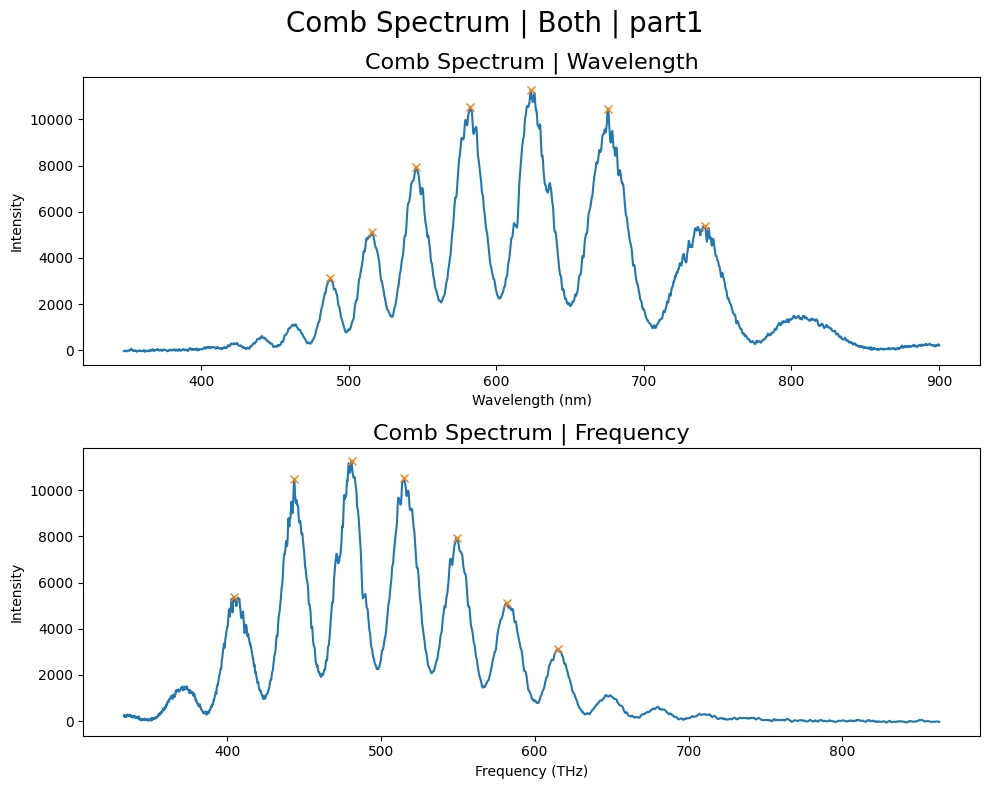

Mean frequency spacing: 35.136 ± 2.427 THz
Δt = 0.028 ± 0.002 psec

Δx = 8.532 ± 0.589 μm



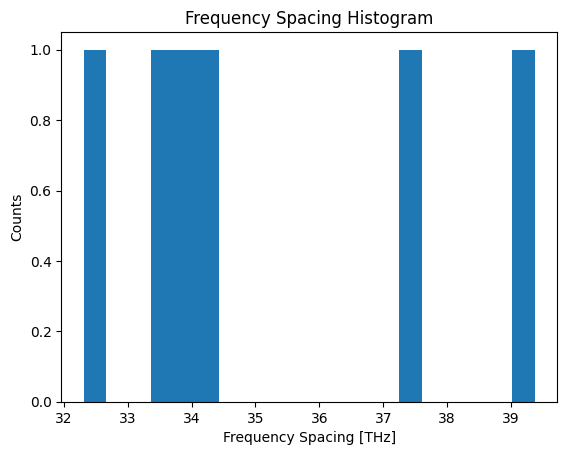

(8.532381545145892, 0.5894541656557003)

In [9]:
file1 = r"interferometry_data\part1.xlsx"
calc_file(file1, plot1 = 'both', plot2 = True, threshold = 2000, width = 10, distance = 40)

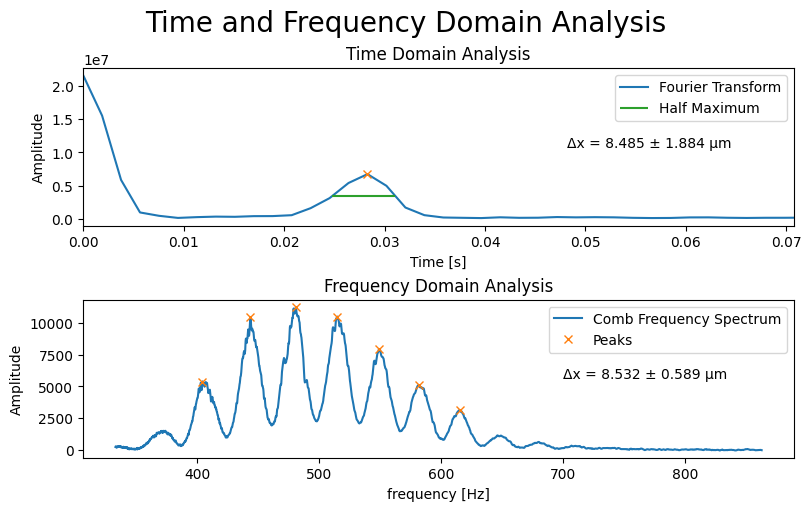

ΔxFP = 8.532 ± 0.589 μm
ΔxFT = 8.485 ± 1.884 μm



In [14]:
file1 = r"interferometry_data\part1.xlsx"
# data1 = load_data(file1)
# peaks = find_peaks_comb(data1, threshold = 1000, width = 10, distance = 50)
# plot_comb(data1, peaks, type = 'freq')
# delta_x1, delta_x_err1 = culc_frec_spacing(data1, peaks, plot = False, toprint = True)

delta_xFT1, delta_xFT1_err, delta_xFP1, delta_xFP1_err = calc_file2(file1, plot = True, threshold = 2000, width = 10, distance = 50)
print('ΔxFP = {:.3f} ± {:.3f} μm'.format(delta_xFP1, delta_xFP1_err))
print('ΔxFT = {:.3f} ± {:.3f} μm\n'.format(delta_xFT1, delta_xFT1_err))

## 2.7 Quantify the Interferometer Translation

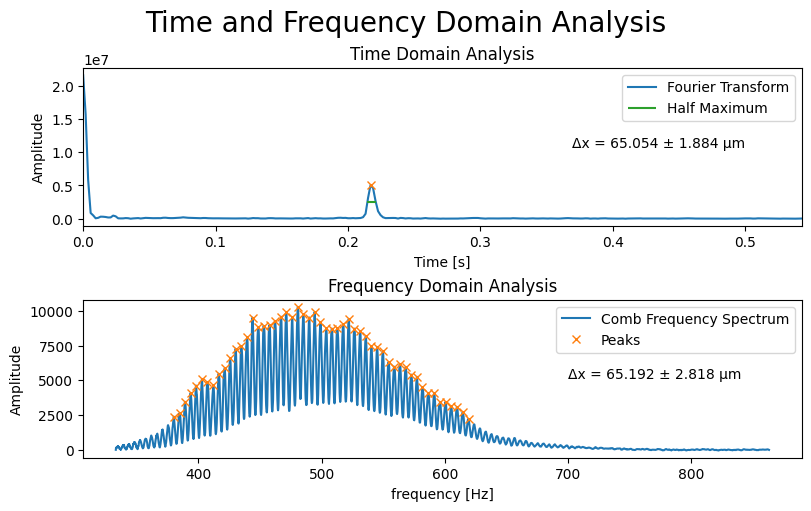

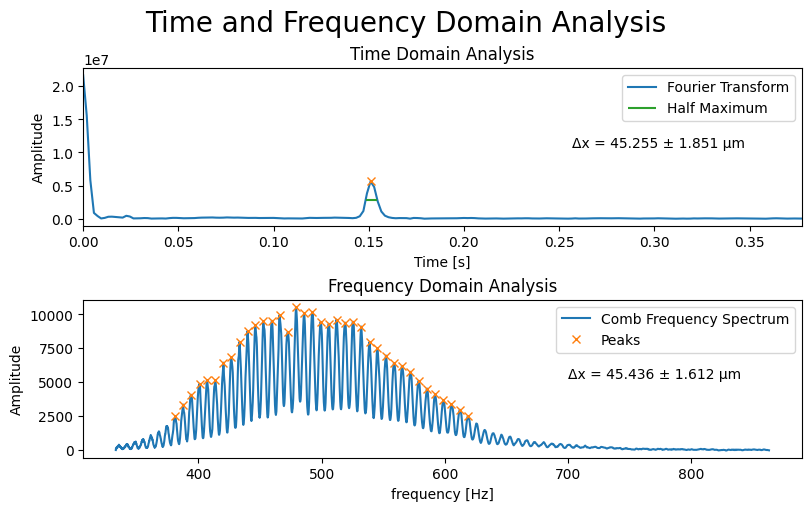

lFT2 = 56.569 ± 2.664 μm
lFP2 = 56.659 ± 2.879 μm

lFT3 = 36.770 ± 2.641 μm
lFP3 = 36.904 ± 1.716 μm


In [4]:
file2 = 'interferometry_data\part_2.xlsx'
file3 = 'interferometry_data\part1_2.xlsx'
delta_xFT2, delta_xFT2_err, delta_xFP2, delta_xFP2_err = calc_file2(file2, plot = True, width = 5, distance = 10)
delta_xFT3, delta_xFT3_err, delta_xFP3, delta_xFP3_err = calc_file2(file3, plot = True, width = 5, distance = 10)
# delta_x2, delta_x_err2 = calc_file(file2, plot1 = 'freq', width = 5, distance = 10)
# delta_x3, delta_x_err3 = calc_file(file3, plot1 = False)

lFT2 = delta_xFT2 - delta_xFT1
lFT3 = delta_xFT3 - delta_xFT1
lFT2_err = np.sqrt(delta_xFT1_err**2 + delta_xFT2_err**2)
lFT3_err = np.sqrt(delta_xFT1_err**2 + delta_xFT3_err**2)

lFP2 = delta_xFP2 - delta_xFP1
lFP3 = delta_xFP3 - delta_xFP1
lFP2_err = np.sqrt(delta_xFP1_err**2 + delta_xFP2_err**2)
lFP3_err = np.sqrt(delta_xFP1_err**2 + delta_xFP3_err**2)


print('lFT2 = {:.3f} ± {:.3f} μm'.format(lFT2, lFT2_err))
print('lFP2 = {:.3f} ± {:.3f} μm\n'.format(lFP2, lFP2_err))

print('lFT3 = {:.3f} ± {:.3f} μm'.format(lFT3, lFT3_err))
print('lFP3 = {:.3f} ± {:.3f} μm'.format(lFP3, lFP3_err))

## 2.8 Intensity Modulation of the Arms

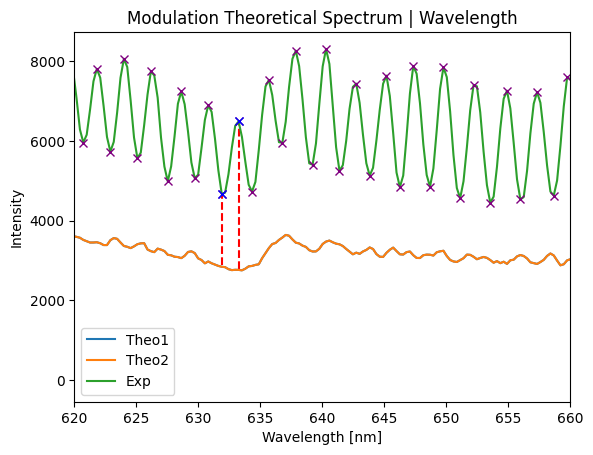

,type,exp,theo
0,max,6490.892398,2766.822692
1,min,4674.435663,2753.871067
2,mod,1.388594,726771.023689


mod_theo = 726771.024
mod_exp = 1.389


In [75]:
mod_theo1_file = 'interferometry_data/mod_theo1.xlsx'
mod_theo2_file = 'interferometry_data/mod_theo2.xlsx'
mod_exp_file = 'interferometry_data/modexp.xlsx'
data_mod_theo1 = load_data(mod_theo1_file)
data_mod_theo2 = load_data(mod_theo2_file)
data_mod_exp = load_data(mod_exp_file)
max_peaks_exp, _ = find_peaks(data_mod_exp['intensity'], height = 4000, distance = 1, width = 1)
min_peaks_exp, _ = find_peaks(-data_mod_exp['intensity'] ,distance = 1, width = 1)

n =56
m =153


plt.vlines(data_mod_exp['wavelength nm'][min_peaks_exp[m]], 2900, data_mod_exp['intensity'][min_peaks_exp[m]], color = 'r', linestyle = '--')
plt.vlines(data_mod_exp['wavelength nm'][max_peaks_exp[n]], 2800, data_mod_exp['intensity'][max_peaks_exp[n]], color = 'r', linestyle = '--')

# mod_theo_resulutsFP = calc_file(mod_theo1_file, plot1 = 'wavel', plot2 = True, width = 4, distance = 60)
plt.plot(data_mod_theo1['wavelength nm'], data_mod_theo1['intensity'], label = 'Theo1')
plt.plot(data_mod_theo1['wavelength nm'], data_mod_theo1['intensity'], label = 'Theo2')
plt.plot(data_mod_exp['wavelength nm'], data_mod_exp['intensity'], label = 'Exp')

plt.plot(data_mod_exp['wavelength nm'][max_peaks_exp], data_mod_exp['intensity'][max_peaks_exp], 'x', color = 'purple') # max of exp
plt.plot(data_mod_exp['wavelength nm'][min_peaks_exp], data_mod_exp['intensity'][min_peaks_exp], 'x', color = 'purple') # min of exp

plt.plot(data_mod_exp['wavelength nm'][max_peaks_exp[n]], data_mod_exp['intensity'][max_peaks_exp[n]], 'x', color = 'blue')
plt.plot(data_mod_exp['wavelength nm'][min_peaks_exp[m]], data_mod_exp['intensity'][min_peaks_exp[m]], 'x', color = 'blue')

# plt.plot(data_mod_theo1['wavelength nm'][max_peaks_exp[m]], data_mod_theo1['intensity'][max_peaks_exp[m]], 'x', label = 'Peaks', color = 'blue')


plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Modulation Theoretical Spectrum | Wavelength')
plt.xlim(620,660)
plt.legend()
plt.show()
# mod_theo_resuluts = calc_file2(mod_theo1_file, plot = True, width = 1, distance = 1)
I1 = data_mod_theo1['intensity'][max_peaks_exp[n]]
I2 = data_mod_theo2['intensity'][max_peaks_exp[n]]
mod_theo = (np.sqrt(I1) + np.sqrt(I2)) ** 2 / (np.sqrt(I1) - np.sqrt(I2)) ** 2
mod_exp = data_mod_exp['intensity'][max_peaks_exp[n]] / data_mod_exp['intensity'][min_peaks_exp[m]]
df = pd.DataFrame({'type':['max','min','mod']\
                   ,'exp': [data_mod_exp['intensity'][max_peaks_exp[n]], data_mod_exp['intensity'][min_peaks_exp[m]], mod_exp],\
                    'theo': [I1, I2, mod_theo]})
display(df)

print('mod_theo = {:.3f}'.format(mod_theo))
print('mod_exp = {:.3f}'.format(mod_exp))

## 2.9 Demonstrate the Law of Energy Conservation


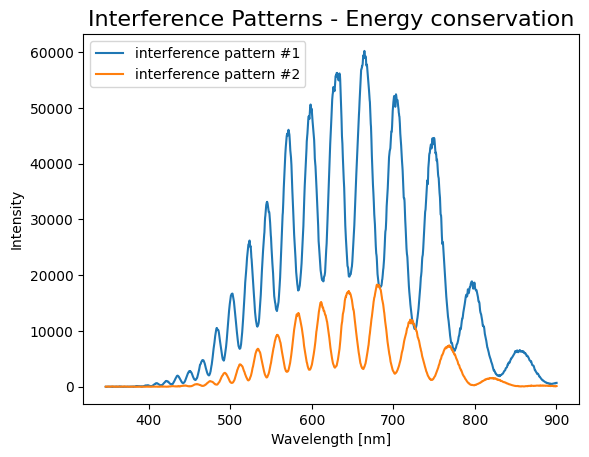

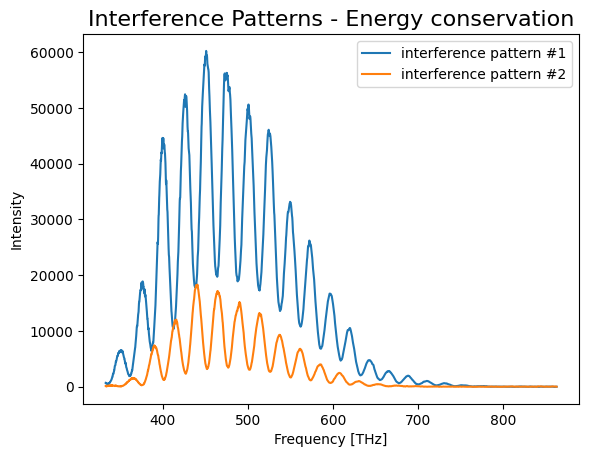

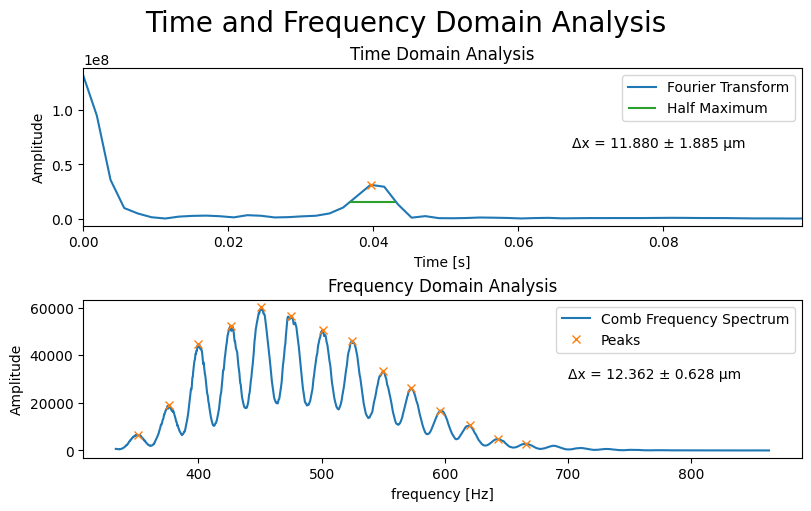

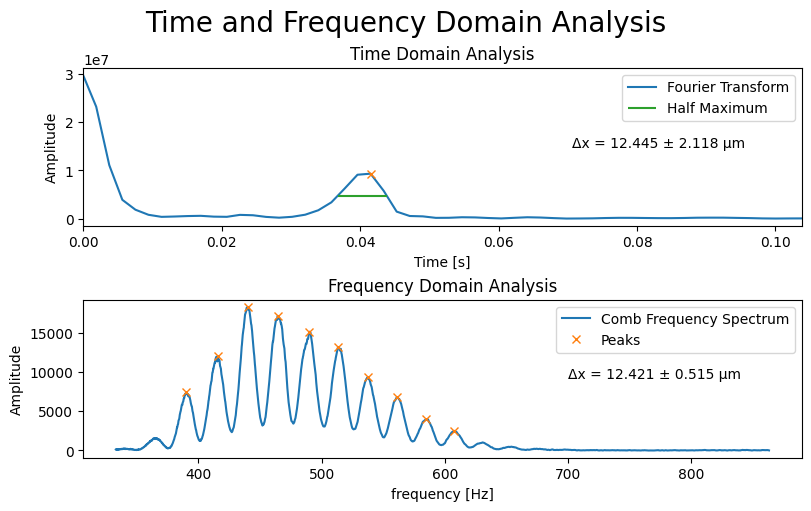

Energy conservation: 0.2991717103286822
0.22583795392032951
0.22583795392032951


In [110]:
file_energy1 = os.path.join("interferometry_data", "erg_no_BS_new.xlsx")
file_energy2 = os.path.join("interferometry_data", "erg_bs_new.xlsx")
data_energy1 = load_data(file_energy1)
data_energy2 = load_data(file_energy2)

wavelegth = data_energy1['wavelength nm']
freq = c / wavelegth * 1e-3 # convert to THz
intensity1 = data_energy1['intensity'] # / np.max(data_energy1['intensity'])
intensity2 = data_energy2['intensity'] # / np.max(data_energy2['intensity'])
# data_energy1['intensity'] = data_energy1['intensity']
# data_energy2['intensity'] = 

# phase difference
plt.plot(wavelegth, intensity1, label = 'interference pattern #1')
plt.plot(wavelegth, intensity2, label = 'interference pattern #2')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Interference Patterns - Energy conservation', fontsize = 16)
plt.legend()
plt.show()
# plot in frequency domain
plt.plot(freq, intensity1, label = 'interference pattern #1')
plt.plot(freq, intensity2, label = 'interference pattern #2')
plt.xlabel('Frequency [THz]')
plt.ylabel('Intensity')
plt.title('Interference Patterns - Energy conservation', fontsize = 16)
plt.legend()
plt.show()

# energy conservation
x = calc_file2(file_energy1, plot = True, erg = True, data =  data_energy1)
y = calc_file2(file_energy2, plot = True, erg = True, data =  data_energy2)
max1 = x[-1] #/ np.max(data_energy1['intensity'])
max2 = y[-1] #/ np.max(data_energy2['intensity'])
print('Energy conservation:', max2 / max1)

print(sum(data_energy2['intensity']) / sum(data_energy1['intensity']))
print(sum(intensity2) / sum(intensity1))


c:\Users\yaniv\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


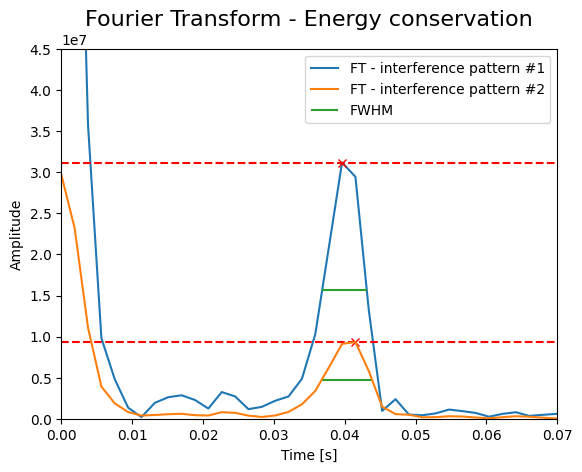

In [30]:
file_energy1 = os.path.join("interferometry_data", "erg_no_BS_new.xlsx")
file_energy2 = os.path.join("interferometry_data", "erg_bs_new.xlsx")
data_energy1 = load_data(file_energy1)
data_energy2 = load_data(file_energy2)

tf1, yf1, tf_max1, tf_err1, yf_max1, FWHM_data1 = FT_calc(data_energy1)
tf2, yf2, tf_max2, tf_err2, yf_max2, FWHM_data2 = FT_calc(data_energy2)
max_peak1 = np.argmax(yf_max1)
max_peak2 = np.argmax(yf_max2)
plt.plot(tf1, yf1, label = 'FT - interference pattern #1')
plt.plot(tf_max1, yf_max1, 'x', color = 'red') # plot the peaks
plt.hlines([yf_max1[0], yf_max2],0,0.07, color="red", ls = '--') # plot the FWHM_data1
plt.plot(tf_max2, yf_max2, 'x' , color = 'red') # plot the peaks
plt.hlines(*FWHM_data2, color="C2") # plot the FWHM_data1
plt.plot(tf2, yf2, label = 'FT - interference pattern #2')
plt.hlines(*FWHM_data1, color="C2", label= 'FWHM') # plot the FWHM_data1
plt.xlim(0, 0.07)
plt.ylim(0, 0.45e8)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Fourier Transform - Energy conservation', fontsize = 16)
plt.legend()
plt.show()


In [ ]:
def calc_file2(file_path, plot = False, limx = False, limy = False, adjpeak = None,ignore = None,erg = False,data = None,**kwargs):
    if data is None:
        data = load_data(file_path)
    # Prefom FT
    tf, yf, tf_max, tf_err, yf_max, FWHM_data = FT_calc(data)
    if adjpeak is not None:
        max_peak = adjpeak
    else:
        max_peak = np.argmax(yf_max)
    # print(tf_max, yf_max, max_peak)

    tf_max = [max_peak]
    peak_Intens = yf_max[max_peak]
    if plot:
        fig, (ax_t, ax_v) = plt.subplots(2, 1, constrained_layout=True, figsize=(8, 5))

        if not limx:
            limx = (0, tf_max[max_peak] * 2.5)

        x_text =limx[1] * 1.7 / 2.5
        if limy:
            y_text = (limy[0] + limy[1]) / 2
        else: 
            y_text = (np.max(yf) + np.min(yf)) / 2
        # plot time domain (FT)
        ax_t.plot(tf, yf, label= 'Fourier Transform') # plot the FT
        if adjpeak is not None:
            ax_t.plot(tf_max[adjpeak], yf_max[adjpeak], 'x')
            ax_t.hlines(FWHM_data[0][adjpeak],FWHM_data[1][adjpeak],FWHM_data[2][adjpeak], color="C2", label="Half Maximum") # plot the FWHM
        else:
            ax_t.plot(tf_max, yf_max, 'x', label= '') # plot the peaks
            ax_t.hlines(*FWHM_data, color="C2", label="Half Maximum") # plot the FWHM
        ax_t.text(x_text,y_text, 'Δx = {:.3f} ± {:.3f} μm'.format(delta_xFT, delta_xFT_err))
        ax_t.set_xlabel('Time [s]')
        ax_t.set_ylabel('Amplitude')
        ax_t.set_xlim(*limx)
        if limy:    
            ax_t.set_ylim(*limy)
        ax_t.set_title('Time Domain Analysis')
        ax_t.legend()

## 2.10 Measure the Index of Refraction of a Solid Sample

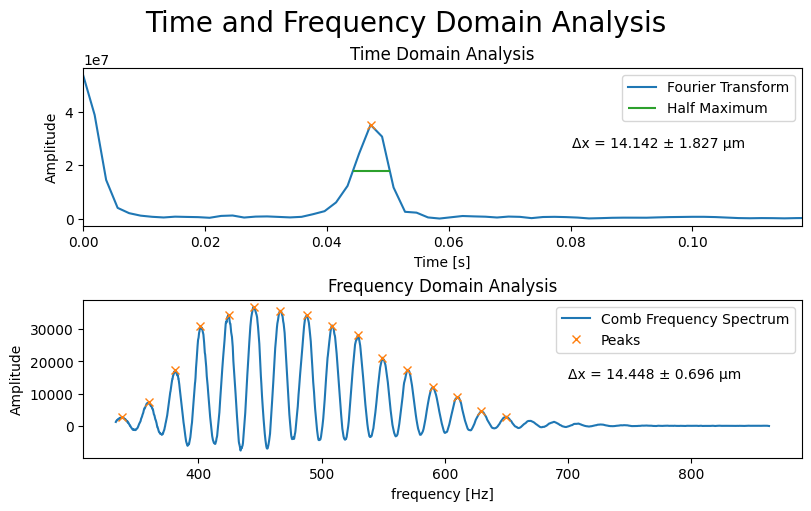

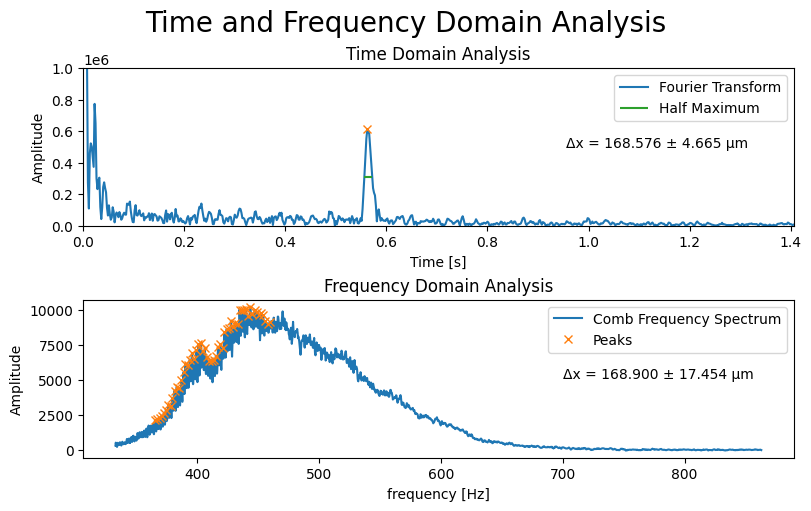

l_FT = 154.434 ± 5.010 μm
l_FP = 154.452 ± 17.468 μm

Δn_FT = 0.429 ± 0.014
Δn_FP = 0.429 ± 0.049

n_FT = 1.428982 ± 0.013915
n_FP = 1.429033 ± 0.048522


In [44]:
reference_file = 'interferometry_data\without2 glass3.xlsx'
mesure_file = 'interferometry_data\with glass3best.xlsx'
# plt.xlim(320,500)
# calc_file(mesure_file, plot1 = 'freq', plot2 = True,width = 3, distance = 2)
d = 180 # sample thickness in um 
res = extract_reflective_index(mesure_file, reference_file, d, adjpeak =1, plot = True,width = 3, distance = 3, threshold = 2000,ignore=(350,460), limy = (0, 1e6))

## 2.11 Measure the Index of Refraction Dependence on the Concentration of a Solution

### Refrence

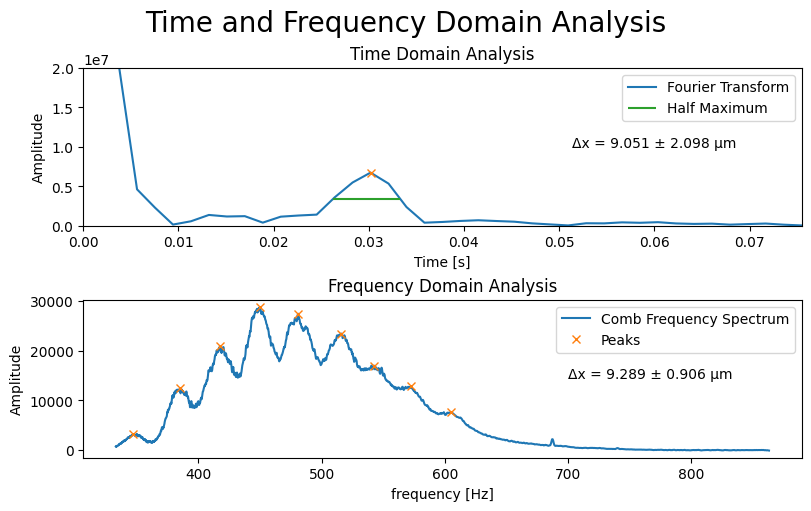

(9.051049553196766, 2.0980660418234804, 9.289003463339663, 0.9056992257620268)

In [52]:
reference_file = 'interferometry_data\sucrose\suc0.xlsx'

calc_file2(reference_file, plot = True, width = 5, distance = 100, threshold = 2000, limy = (0, 2e7))

### Sucrose

,C[M],file_name,nFT,nFT_err,nFP,nFP_err
0,0.000000,suc0.xlsx,1.000000,0.000001,1.000000,0.000001
1,0.048667,suc1.xlsx,1.000001,0.000002,1.000002,0.000001
2,0.091250,suc2.xlsx,1.000002,0.000002,1.000003,0.000001
3,0.128824,suc3.xlsx,1.000005,0.000002,1.000005,0.000001
4,0.162222,suc4.xlsx,1.000006,0.000002,1.000007,0.000001
5,0.192105,suc5.xlsx,1.000007,0.000002,1.000007,0.000004
6,0.219000,suc6.xlsx,1.000010,0.000002,1.000008,0.000005
7,0.243333,suc7.xlsx,1.000012,0.000002,1.000008,0.000004


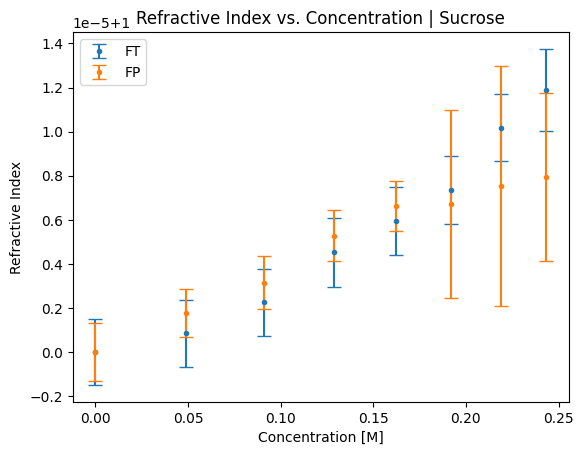

In [46]:
concentration_file = os.path.join("interferometry_data","conc_interferometer.xlsx")
concentration_data = pd.read_excel(concentration_file, sheet_name= 'sucrose - py')
data_folder = os.path.join('interferometry_data','sucrose')
reference_file = 'interferometry_data\sucrose\suc0.xlsx'
d = 1e6 # cuvettes thickness in um

nFT_list = []
nFT_err_list = []
nFP_list = []
nFP_err_list = []

for file in concentration_data['file_name']:
    file_path = os.path.join(data_folder, file)
    n_FT, n_FT_err, n_FP, n_FP_err = extract_reflective_index(file_path, reference_file, d, plot = False)
    nFT_list.append(n_FT)
    nFT_err_list.append(n_FT_err)
    nFP_list.append(n_FP)
    nFP_err_list.append(n_FP_err)

concentration_data['nFT'] = nFT_list
concentration_data['nFT_err'] = nFT_err_list
concentration_data['nFP'] = nFP_list
concentration_data['nFP_err'] = nFP_err_list
display(concentration_data)

plt.errorbar(concentration_data['C[M]'], concentration_data['nFT'], yerr=concentration_data['nFT_err'], fmt='.', label = 'FT', capsize=5)
plt.errorbar(concentration_data['C[M]'], concentration_data['nFP'], yerr=concentration_data['nFP_err'], fmt='.', label= 'FP', capsize=5)
plt.xlabel('Concentration [M]')
plt.ylabel('Refractive Index')
plt.title('Refractive Index vs. Concentration | Sucrose')
plt.legend()
plt.show()


,C[M],file_name,nFT,nFT_err,nFP,nFP_err
1,0.048667,suc1.xlsx,1.000849,0.001904,1.000877,0.001102
2,0.091250,suc2.xlsx,1.002263,0.001892,1.002289,0.001181
3,0.128824,suc3.xlsx,1.004526,0.001943,1.004633,0.001235
4,0.162222,suc4.xlsx,1.005940,0.001926,1.005965,0.001211
5,0.192105,suc5.xlsx,1.007354,0.001928,1.007215,0.001308
6,0.219000,suc6.xlsx,1.010182,0.001901,1.010092,0.001317
7,0.243333,suc7.xlsx,1.011880,0.002192,1.011860,0.001467


chi^2 reduced for FT: 0.13
chi^2 reduced for FP: 0.35


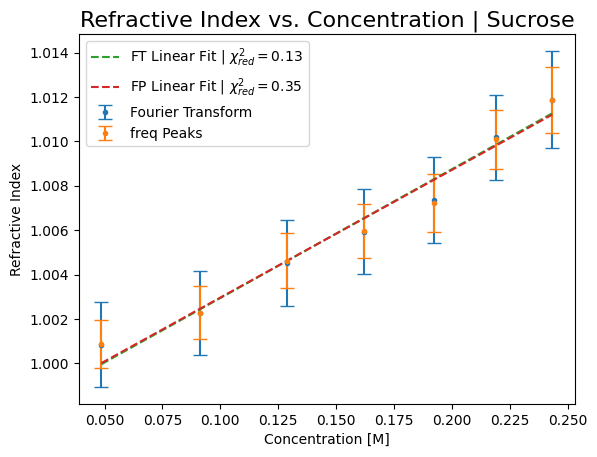

In [69]:
from scipy.odr import ODR, Model, RealData

concentration_file = os.path.join("interferometry_data","conc_interferometer.xlsx")
concentration_data = pd.read_excel(concentration_file, sheet_name= 'sucrose - py')
data_folder = os.path.join('interferometry_data','sucrose')
reference_file = 'interferometry_data\sucrose\suc0.xlsx'
d = 1e3 # cuvettes thickness in um

delta_xFT_ref, delta_xFT_err_ref, delta_xFP_ref, delta_xFP_err_ref = calc_file2(reference_file,plot = False, width = 5, distance = 100, threshold = 2000) # um

FT_list = [delta_xFT_ref]
FT_err_list = [delta_xFT_err_ref]
FP_list = [delta_xFP_ref]
FP_err_list = [delta_xFP_err_ref]


file_path = os.path.join(data_folder, 'suc1.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 70, threshold = 2300) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc2.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 55, threshold = 2000) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc3.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 40, threshold = 2000) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc4.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 38, threshold = 2000, ignore=(0,605)) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc5.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 38, threshold = 2000, ignore=(0,600)) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc6.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 5, distance = 38, threshold = 2000, ignore=(0,540)) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

file_path = os.path.join(data_folder, 'suc7.xlsx')
delta_xFT_mes, delta_xFT_err_mes, delta_xFP_mes, delta_xFP_err_mes = calc_file2(file_path, plot = False, width = 2, distance = 27, threshold = 8000, ignore=(430,640), limy= (0,2e7)) # um
FT_list.append(delta_xFT_mes)
FT_err_list.append(delta_xFT_err_mes)
FP_list.append(delta_xFP_mes)
FP_err_list.append(delta_xFP_err_mes)

# print('FT_list:', FT_list)
concentration_data['nFT'] = (np.array(FT_list) - delta_xFT_ref) / (2 * d) + 1
concentration_data['nFT_err'] = np.sqrt(np.array(FT_err_list)**2 + delta_xFT_err_mes**2) / (2 * d)
concentration_data['nFP'] =(np.array(FP_list) - delta_xFP_ref) / (2 * d) + 1
concentration_data['nFP_err'] = np.sqrt(np.array(FP_err_list)**2 + delta_xFP_err_mes**2) / (2 * d)
concentration_data.drop(0, inplace = True)
display(concentration_data)
plt.errorbar(concentration_data['C[M]'], concentration_data['nFT'], yerr=concentration_data['nFT_err'], fmt='.', label = 'Fourier Transform', capsize=5)
plt.errorbar(concentration_data['C[M]'], concentration_data['nFP'], yerr=concentration_data['nFP_err'], fmt='.', label= 'freq Peaks', capsize=5)

def linear_func(p, x):
    return p[0] * x + p[1]

linear_model = Model(linear_func)

# Prepare data for FT
data_FT = RealData(concentration_data['C[M]'], concentration_data['nFT'], sx=None, sy=concentration_data['nFT_err'])
odr_FT = ODR(data_FT, linear_model, beta0=[1., 0.])
output_FT = odr_FT.run()
slope_FT, intercept_FT = output_FT.beta
slope_FT_err, intercept_FT_err = output_FT.sd_beta

# Prepare data for FP
data_FP = RealData(concentration_data['C[M]'], concentration_data['nFP'], sx=None, sy=concentration_data['nFP_err'])
odr_FP = ODR(data_FP, linear_model, beta0=[1., 0.])
output_FP = odr_FP.run()
slope_FP, intercept_FP = output_FP.beta
slope_FP_err, intercept_FP_err = output_FP.sd_beta

# Plot the fit results
x_fit = np.linspace(concentration_data['C[M]'].min(), concentration_data['C[M]'].max(), 100)
y_fit_FT = linear_func(output_FT.beta, x_fit)
y_fit_FP = linear_func(output_FP.beta, x_fit)
# Calculate chi^2 reduced for FT
chi2_FT = np.sum(((concentration_data['nFT'] - linear_func(output_FT.beta, concentration_data['C[M]'])) / concentration_data['nFT_err'])**2)
chi2_red_FT = chi2_FT / (len(concentration_data) - len(output_FT.beta))
print(f'chi^2 reduced for FT: {chi2_red_FT:.2f}')

# Calculate chi^2 reduced for FP
chi2_FP = np.sum(((concentration_data['nFP'] - linear_func(output_FP.beta, concentration_data['C[M]'])) / concentration_data['nFP_err'])**2)
chi2_red_FP = chi2_FP / (len(concentration_data) - len(output_FP.beta))
print(f'chi^2 reduced for FP: {chi2_red_FP:.2f}')
plt.plot(x_fit, y_fit_FT, ls = '--', label=r'FT Linear Fit | $\chi^2_{red}=$' + f'{chi2_red_FT:.2f}')
plt.plot(x_fit, y_fit_FP, ls = '--', label=r'FP Linear Fit | $\chi^2_{red}=$' + f'{chi2_red_FP:.2f}')

plt.xlabel('Concentration [M]')
plt.ylabel('Refractive Index')
plt.title('Refractive Index vs. Concentration | Sucrose', fontsize = 16)
plt.legend()
plt.show()


## Noise Spectrum

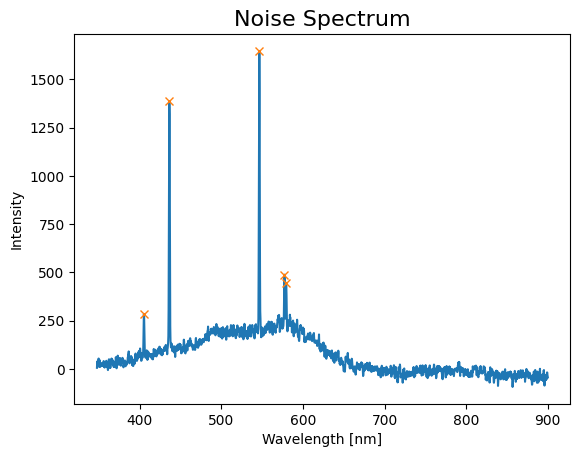

,λ [nm],intensity
197,404.9,284.7
305,436.1,1386.8
694,546.5,1647.9
805,577.3,488.5
812,579.2,446.4


In [71]:
file = r'interferometry_data\noise.xlsx'
data = load_data(file)
peaks, _ = find_peaks(data['intensity'], height = 250, distance = 3, width = 3, prominence= 100)
plt.plot(data['wavelength nm'], data['intensity'])
plt.plot(data['wavelength nm'][peaks], data['intensity'][peaks], 'x')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Noise Spectrum'  , fontsize = 16)
plt.show()

df = pd.DataFrame({'λ [nm]': data['wavelength nm'][peaks].round(1), 'intensity': data['intensity'][peaks].round(1)})
display(df)